In [1]:
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [14]:
#import spike
#from spike.Interactive import INTER as I 
#I.hidecode(message="")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, plot, figure, text, title, xlabel, ylabel, subplots
import numpy as np
from numpy import exp, cos, sin, arctan2, pi, linspace, arange

import spike
from spike.File import BrukerMS as bkMS

from ipywidgets import Button, interactive, interact, FloatSlider, IntSlider
import ipywidgets as widgets
from IPython.display import display, HTML, Javascript, Markdown, Image

matplotlib.style.use("fivethirtyeight")
for i in ('font.size','axes.labelsize','legend.fontsize','legend.title_fontsize'):
    matplotlib.rcParams[i]=24
for i in ('xtick.labelsize', 'ytick.labelsize'):
    matplotlib.rcParams[i]=18

#matplotlib.style.available


          SPIKE
    Version     : 0.99.29
    Date        : 20-09-2021
    Revision Id : 529
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
plugins loaded:
msapmin, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 
*** PALMA not loaded ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  apmin, 


# The basic FTICR experiment
### 2nd-AUS-FTICR
*Marc-André Delsuc - Prague 26-30 Sept 2021*


This work is licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

a developed content of this part can be found on [github.com/delsuc](https://github.com/delsuc/Fourier_Transform/blob/master/Definition_Properties.ipynb)

## classical processing

We are going to go slowly through the steps that produced that nice spectrum earlier.

We will use `SPIKE` a processing library written in python, able to handle all sorts of FT spectrometries ( 😉 )

`SPIKE` is freely available on github : [github.com/spike-project/spike](https://github.com/spike-project/spike)

![](files/Logo.png)

## The process that run on the previous slide

Actually, just a few lines of python

```python
import spike
from spike.File import BrukerMS as bkMS

d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)

D = d.copy().center().kaiser(4).zf(2).rfft().modulus()

figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);
```

Let's go through them slowly...

## First get rid of the syntax problems !

First, load the `SPIKE` environment into this presentation - which is in fact a python program presenting its results in a browser *(amazing if you ask me)* and load the specific tool for reading Bruker FT-ICR files.
```python
import spike
from spike.File import BrukerMS as bkMS
```

Then, import the raw data-set from the instrument and create `d` a python object - and display. <br>
The program takes care of handling all the acquisition parameters.

```python
d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)
```
Then do the processing - *this is where everything takes place*
```python
D = d.copy().center().kaiser(4).zf(2).rfft().modulus()
```

Finally, display the spectrum with a given zoom window
```python
figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);
```


## let's explore the processing
<big> D = d. **copy()** .center().kaiser(4).rfft().zf(2).modulus() </big>

Actions are applied to the object by the mean of the dot " **.** "

in `SPIKE` spectroscopic objects are modified in-place, in order to optimize speed and memory.
 
`d` has been created in memory, we do not want to loose it while doing transformations, so we just `copy()` it <br>and create a new object on which the following actions are applied

<big> D = d.copy().**center().kaiser(4).rfft().zf(2).modulus()** </big>

actions are chained, the whole expression evaluates as the final spectrum.

The processing is done in 5 steps ‼️  ... not just one ❓️

## let's explore the processing - 1 -
<big> D = d.copy(). **center()** .kaiser(4).zf(2).rfft().modulus() </big>

Remember one of the relationships presented in first part: 

#### integrals
$$F_o = \int f(t) dt \quad \quad f_o = \int F(\omega) d \omega$$

So, if a slight miss-adjustment of the 0 of the detector is present, there is be a small continuous constant value added to all measured points.

Added over the whole `fid` this value will show up as a strong spike at $F_o$ the null frequency.

Even if it corresponds to $m/z = \infty$ *(but not in Narrow-Band though)* it might creates round-off errors in the processing because of a very strong dynamics.

So we just compute a **centering** of the data-set to remove this artefact.

## let's explore the processing - 2 -
<big> D = d.copy().center(). **kaiser(4)** .zf(2).rfft().modulus() </big>

This is the very important **Apodisation** step.

It consists in pre-multiplying the `fid ` with some shape, with a strong impact on the lineshape, resolution and noise level in the final spectrum.

It is deeply related to the convolution theorem - which we will go through now...

## Convolution
We have seen that Linearity means the
at**FT of sum** is **sum of FT**

if linearity is for addition, convolution is for multiplication.

Convolution of two functions $f$ and $g$ is defined as: (noting it here $\circledast$ )
$$
(f \circledast g)(t') = \int_{-\infty}^{\infty} f(t) g(t-t')dt
$$

Then the convolution theorem states that  **FT of product** is **convolution of FT**

This is a symmetric operation for $f$ and $g$, and can be described as $f$ and $g$ sharing their shapes.

Difficult to apprehend, Let see it in action:

In [3]:
def ftcv(frequency = 3.0, truncating_to=30, broadening=2.0):
    "showing convolution"
    freq = frequency
    N = truncating_to
    br = broadening
    x = np.linspace(0,10,1000)    # a vector of 1000 points equi distant from 0.0 to 10.0
    y = np.cos(2*np.pi*freq*x)
    g = np.zeros_like(x)
    g[0:N] = 1.0
    apod = g*np.exp(-br*x**2)
    y = y*apod
    YY = np.fft.rfft(y,n=1000)
    yax = np.linspace(0,50,501)
    f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,6))
    ax1.plot(apod, ':k', lw=2)
    ax1.plot(y.real)
    ax1.set_ylim(ymin=-1.1, ymax=1.1)
    ax1.set_xlim(xmax=400)
    ax2.plot(yax, abs(YY))
    ax2.set_xlim(xmax=20)
display(Markdown("""## Toy Convolution
one cosinuoid of 500 points, truncated and premultiplied with an exponential"""))
interact(ftcv,
        frequency=FloatSlider(min=0, max=20, value=3, continuous_update=False),
        truncating_to=IntSlider(min=2,max=1000, value=1000, continuous_update=False),
        broadening=FloatSlider(min=0,max=5, value=0, continuous_update=False))
#interactive( ftcv, frequency=(0.0,50.0), truncating_to=(4,500), broadening=(0,30))

## Toy Convolution
one cosinuoid of 500 points, truncated and premultiplied with an exponential

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='frequency', max=20.0), IntS…

<function __main__.ftcv(frequency=3.0, truncating_to=30, broadening=2.0)>

## Classical apodisation functions

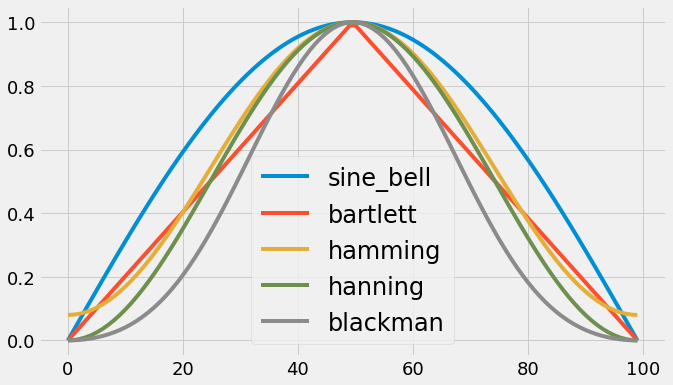

In [4]:
from numpy import blackman, hamming, hanning, bartlett, kaiser  # these are pre-defined
def sine_bell(N):                                       # this one is missing
    "defines the sine-bell apodisation window"
    return np.sin( np.linspace(0,np.pi,N) )
display(Markdown("""## Classical apodisation functions"""))
figure(figsize=(10,6))
for apod in ("sine_bell", "bartlett", "hamming", "hanning", "blackman"):
    y = eval("%s(100)"%(apod))
    plt.plot(y,label=apod)
plt.legend();

The **kaiser** function is also very usefull as a generic/tunable apodisation function.

```python
kaiser(beta=...)
```

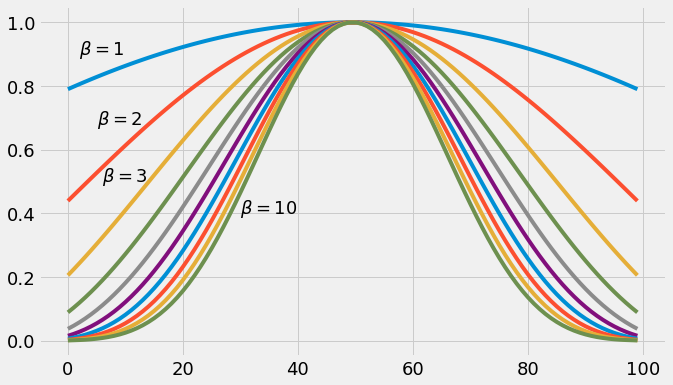

In [9]:
display(Markdown("""The **kaiser** function is also very usefull as a generic/tunable apodisation function.

```python
kaiser(beta=...)
```"""))

plt.figure(figsize=(10,6))
for beta in range(1,11):
    plt.plot(kaiser(100, beta), label=r"$\beta=%.1f$"%beta)
#plt.legend()
plt.text(2,0.9,r"$\beta=1$",fontsize=18)
plt.text(5,0.68,r"$\beta=2$",fontsize=18)
plt.text(6,0.5,r"$\beta=3$",fontsize=18)
plt.text(30,0.4,r"$\beta=10$",fontsize=18);
#plt.title(r'The Kaiser($\beta$) apodisation');

In [13]:
apodlist = ["None", "sine_bell", "bartlett", "hamming", "hanning", "blackman", "kaiser"]
def ftapod(freq1 = 10.0, freq2 = 20.0, br=0.5, N=150, apod="empty", beta=3.0, noise=0):
    "showing convolution"
    x = np.linspace(0,10,1000)    # a vector of 1000 points equi distant from 0.0 to 10.0
    y = np.cos(2*pi*freq1*x) + np.cos(2*pi*freq2*x)
    g = np.zeros_like(x)
    if apod == 'None':
        g[0:N] = 1.0
    elif apod == 'kaiser':
        g[0:N] = eval("%s(%d,%f)"%(apod,N,beta))
    elif apod != 'None':
        g[0:N] = eval("%s(%d)"%(apod,N))
    y *= np.exp(-br*x**2)
    if noise>0:
        y += noise*np.random.randn(1000)
    ymax = max(y)
    YY = np.fft.rfft(y*g,n=1000)
    yax = np.linspace(0,50,501)
    f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(12,6))
    ax1.plot(ymax*g, ':k', lw=2)
    ax1.plot(y*g)
    ax1.set_ylim(ymin=-1.1*ymax, ymax=1.1*ymax)
    ax1.set_xlim(xmax=400)
    ax2.plot(yax, abs(YY))
    ax2.set_xlim(xmax=20)
display(Markdown("""## Exploring a slightly more realistic signal"""))

from ipywidgets import interactive_output, Dropdown, HBox, VBox, Label
freq1 = FloatSlider(description='Freq1',min=0, max=20, value=13, continuous_update=False)
freq2 = FloatSlider(description='Freq2',min=0, max=20, value=14, continuous_update=False)
beta = FloatSlider(description='β',min=1.0, max=10.0, value=4, continuous_update=False)
truncating_to = IntSlider(description='Truncation to',min=2,max=1000, value=1000, continuous_update=False)
broadening = FloatSlider(description='Broadening',min=0,max=1, value=0, continuous_update=False)
noise = FloatSlider(description='added noise',min=0, max=3, value=0, continuous_update=False)
apodisation = Dropdown(description='Apodisation',options=apodlist)
uibox = VBox([HBox([freq1, freq2]),
              HBox([truncating_to, broadening, noise]),
              HBox([apodisation, beta, Label('(β used by Kaiser only)')])])
out = interactive_output( ftapod,
    {'freq1':freq1, 'freq2':freq2, 'br':broadening, 'N':truncating_to, 'apod':apodisation, 'beta':beta, 'noise':noise})
display(uibox, out)

## Exploring a slightly more realistic signal

Output()

Explore the effect of truncation and apodisation with respect to signal life-time and noise level.

## let's explore the processing - 3 & 4-
<big> D = d.copy().center().kaiser(4). **zf(2)** .rfft().modulus() </big>

- **zerofilling** consists in adding zeros to the data-set *before* FT. 
- what we've seen about truncation is an example
- improves numerical resolution - here doubling the number of points
- we'll see in  step **5** that it is actually a requisite !

<big> D = d.copy().center().kaiser(4).zf(2). **rfft()** .modulus() </big>

- This is the Fourier step - this is actually the simpler step -
- However, there are some subtilities here that we will see later on



## let's explore the processing - 5 -
<big> D = d.copy().center().kaiser(4).rfft().zf(2). **modulus()** </big>

This step replaces the complex series $X_i$ produced by FT by its modulus $|X_i|$

What happens if we don't do that ?

```python
d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)

D = d.copy().center().kaiser(4).zf(2).rfft()

figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);
```

Using 3 parameters calibration,  Warning calibB is -ML2


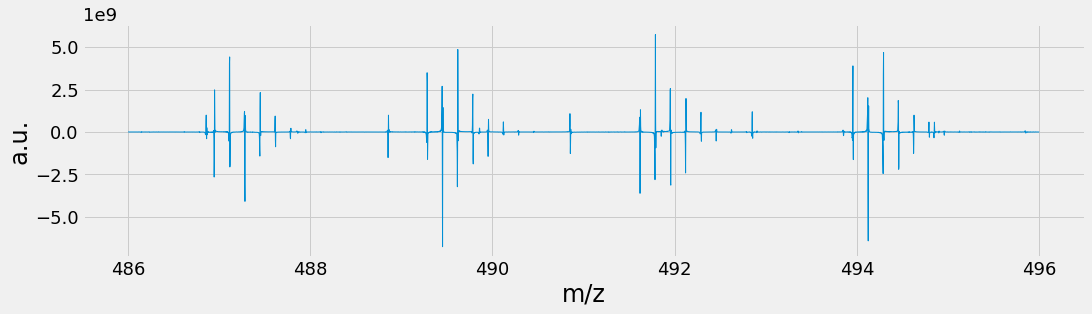

In [20]:
d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")

D = d.copy().center().kaiser(4).zf(2).rfft()

figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(486, 496),new_fig=False);


15 slides


- acqu
    - zf
    - modulus
    - definition and measure of resolution
    - comparing strategies
- complex: real / imaginary
    - and time/freq asymmetry
        - due topoint 0 => odd number
    - 3 DFT
        - fft - rfft - fftr
    - causal signal
    - KK
    - Hilbert transform
- phase
    - phase one signal in the time domain
    - phase complete spectrum
    - effect of the pulse
        - narrow band spectra
        - 1st order correction
    - broad band spectra
        - 2nd order correction
        - Kilgour
        - MAD manual
- Gabor theorem
    - link with convolution
    - assumptions / limitations
- ion cloud dynamic
    - and line-shape
    - instantaneous freq
        - FT
        - FDM
        - FISTA
        - ...
    - and excitation
        - quadratic phase dependence